In [4]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import optimize
from matplotlib.ticker import FormatStrFormatter

In [5]:
sdir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_2366_sw_2/'

savedir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_2366_sw_2/Spectra/'

if not os.path.exists(savedir):
    os.makedirs(savedir)

fits_name = 'NGC_2366_sw_2.fits'

In [6]:
hdulist = fits.open(sdir + fits_name)

hdulist.info()

Filename: /Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_2366_sw_2/NGC_2366_sw_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     329   ()      
  1  FLUX          1 ImageHDU        28   (33, 35, 49)   float64   
  2  ERROR         1 ImageHDU        28   (33, 35, 49)   float64   
  3  UNCORRECTED_FLUX    1 ImageHDU        28   (33, 35, 49)   float64   
  4  UNCORRECTED_ERROR    1 ImageHDU        28   (33, 35, 49)   float64   
  5  WAVELENGTH    1 ImageHDU         7   (49,)   float64   
  6  X             1 ImageHDU         7   (33,)   float64   
  7  Y             1 ImageHDU         7   (35,)   float64   
  8  TRANSMISSION    1 ImageHDU         7   (49,)   float64   
  9  RESPONSE      1 ImageHDU         7   (49,)   float64   
 10  EXPOSURE_MAP    1 ImageHDU        28   (33, 35, 49)   int16   
 11  UNSMOOTHED_TRANSMISSION    1 ImageHDU         8   (1277, 2)   float64   


In [7]:
wavelengths = hdulist[5].data
print(wavelengths)

[57.14274267 57.1507058  57.15866892 57.16663205 57.17459517 57.1825583
 57.19052143 57.19848455 57.20644768 57.2144108  57.22237393 57.23033705
 57.23830018 57.24626331 57.25422643 57.26218956 57.27015268 57.27811581
 57.28607893 57.29404206 57.30200519 57.30996831 57.31793144 57.32589456
 57.33385769 57.34182081 57.34978394 57.35774707 57.36571019 57.37367332
 57.38163644 57.38959957 57.3975627  57.40552582 57.41348895 57.42145207
 57.4294152  57.43737832 57.44534145 57.45330458 57.4612677  57.46923083
 57.47719395 57.48515708 57.4931202  57.50108333 57.50904646 57.51700958
 57.52497271]


In [8]:
hdulist[1].header

XTENSION= 'IMAGE   '           /extension type                                  
BITPIX  =                  -64 /bits per data value                             
NAXIS   =                    3 /number of axes                                  
NAXIS1  =                   33 /                                                
NAXIS2  =                   35 /                                                
NAXIS3  =                   49 /                                                
PCOUNT  =                    0 /                                                
GCOUNT  =                    1 /                                                
EXTNAME = 'FLUX    '           /                                                
DATE-OBS= '2019-05-14T08:13:58' / Observation date                              
BUNIT   = 'Jy/pixel'           / Data units                                     
EQUINOX =              2000.00 / Coordinate equinox                             
CTYPE1  = 'RA---TAN'        

In [9]:
wavelengths = hdulist[5].data

x_coords = hdulist[6].data
x_min = x_coords[0]
x_max = x_coords[len(x_coords)-1]

y_coords = hdulist[7].data
y_min = y_coords[0]
y_max = y_coords[len(y_coords)-1]

print(wavelengths)

wav_diff = []

for i in range(0, len(wavelengths)-1):
    wav_diff.append(wavelengths[i+1]-wavelengths[i])
  
wav_diff = np.average(wav_diff)

print(wav_diff)

[57.14274267 57.1507058  57.15866892 57.16663205 57.17459517 57.1825583
 57.19052143 57.19848455 57.20644768 57.2144108  57.22237393 57.23033705
 57.23830018 57.24626331 57.25422643 57.26218956 57.27015268 57.27811581
 57.28607893 57.29404206 57.30200519 57.30996831 57.31793144 57.32589456
 57.33385769 57.34182081 57.34978394 57.35774707 57.36571019 57.37367332
 57.38163644 57.38959957 57.3975627  57.40552582 57.41348895 57.42145207
 57.4294152  57.43737832 57.44534145 57.45330458 57.4612677  57.46923083
 57.47719395 57.48515708 57.4931202  57.50108333 57.50904646 57.51700958
 57.52497271]
0.00796312572046102


In [10]:
# wavelength is the first dimension
# y is the second dimension
# x is the third dimension

fluxmaps = hdulist[1].data

fluxmaps_min = np.nanmin(fluxmaps.flatten())
fluxmaps_max = np.nanmax(fluxmaps.flatten())

print(fluxmaps.shape)

(49, 35, 33)


In [11]:
def sum_spaxel(fluxmap, k_x, k_y):
    
    n_x = len(fluxmap[0])
    n_y = len(fluxmap)
    
    id_x = np.arange(np.floor((n_x-k_x)/2), np.floor((n_x-k_x)/2) + k_x, 1)
    id_x = id_x.astype(int)
    
    id_y = np.arange(np.floor((n_y-k_y)/2), np.floor((n_y-k_y)/2) + k_y, 1)
    id_y = id_y.astype(int)
    
    central_fluxmap = []
    
    for j in id_y:
        
        y_snip = []
        
        for i in id_x:
            
            y_snip.append(fluxmap[j][i])
            
        central_fluxmap.append(y_snip)
            
    central_fluxmap = np.array(central_fluxmap)
    
    central_flux = np.sum(central_fluxmap)
    
    return central_flux

In [12]:
central_fluxes_unfiltered = []

n_x = 5
n_y = 5

for fluxmap in fluxmaps:
    
    central_flux_unfiltered = sum_spaxel(fluxmap, n_x, n_y)
    central_fluxes_unfiltered.append(central_flux_unfiltered)
    
central_fluxes_unfiltered = [flux*(10**(-26)) for flux in central_fluxes_unfiltered]

c = 3*10**8

for i in range(0, len(wavelengths)):
    
    wavelength = wavelengths[i]
    
    central_fluxes_unfiltered[i] = central_fluxes_unfiltered[i]*(c/(wavelength*10**(-6))**2)*(10**(-6))
    
central_fluxes_unfiltered = np.array(central_fluxes_unfiltered)

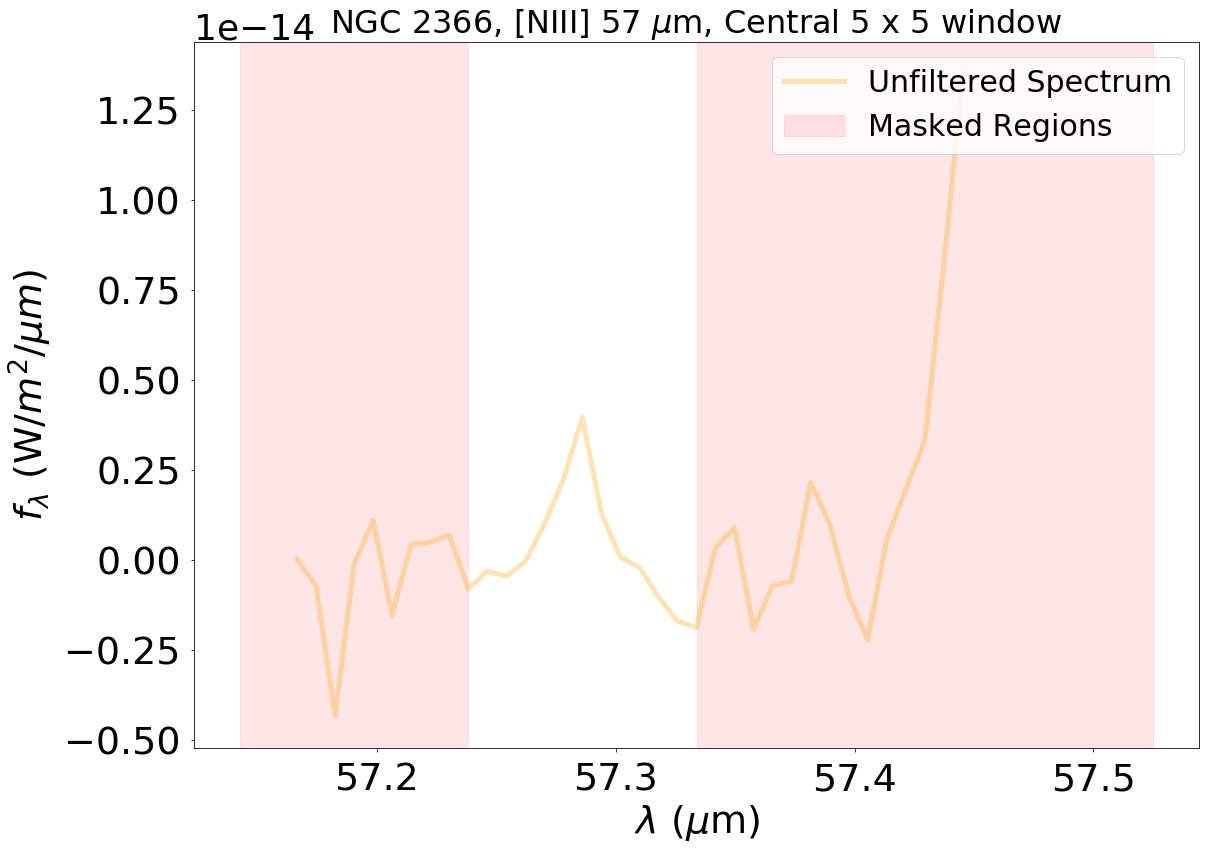

In [20]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.axvspan(wavelengths[0], wavelengths[12], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax.axvspan(wavelengths[-25], wavelengths[-1], color = 'red', alpha = 0.1)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

plt.savefig(savedir + 'NGC_2366_[NIII]-1-unfiltered_spectrum.png'.format(str(n_x), str(n_y)))

ax.legend(prop={'size': 30}, loc = 'upper right')

In [21]:
print(central_fluxes_unfiltered)

[            nan             nan             nan  1.44846895e-17
 -7.20965705e-16 -4.34704193e-15 -1.24973954e-16  1.09345546e-15
 -1.53349859e-15  4.32103807e-16  4.91446318e-16  6.86497637e-16
 -8.02373960e-16 -3.16238052e-16 -4.54822504e-16 -5.65851499e-17
  9.86182429e-16  2.22854171e-15  3.96145714e-15  1.28834076e-15
  7.41301613e-17 -2.12059499e-16 -1.03140450e-15 -1.70612209e-15
 -1.88073190e-15  3.44396018e-16  8.86221304e-16 -1.92787368e-15
 -7.19122989e-16 -5.93326244e-16  2.14656891e-15  1.00079583e-15
 -1.00271581e-15 -2.21946782e-15  5.52207039e-16  1.96802951e-15
  3.30210900e-15  8.20774896e-15  1.35078559e-14             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan]


In [34]:
central_fluxes_filtered = central_fluxes_unfiltered
central_fluxes_filtered = central_fluxes_filtered[12:-24]

wavelengths_filtered = wavelengths[12:-24]

print(central_fluxes_filtered)

[-8.02373960e-16 -3.16238052e-16 -4.54822504e-16 -5.65851499e-17
  9.86182429e-16  2.22854171e-15  3.96145714e-15  1.28834076e-15
  7.41301613e-17 -2.12059499e-16 -1.03140450e-15 -1.70612209e-15
 -1.88073190e-15]


In [37]:
central_fluxes_filtered_continuum = []

left_cut = 57.24
right_cut = 57.32

for i in range(0, len(wavelengths_filtered)):
    
    wavelength = wavelengths_filtered[i]
    
    if(wavelength < left_cut or wavelength > right_cut):
        central_fluxes_filtered_continuum.append(central_fluxes_filtered[i])
    
    else:
        central_fluxes_filtered_continuum.append(float("Nan"))
        
central_fluxes_filtered_continuum = np.array(central_fluxes_filtered_continuum)

print(central_fluxes_filtered_continuum)

[-8.02373960e-16             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan -1.70612209e-15
 -1.88073190e-15]


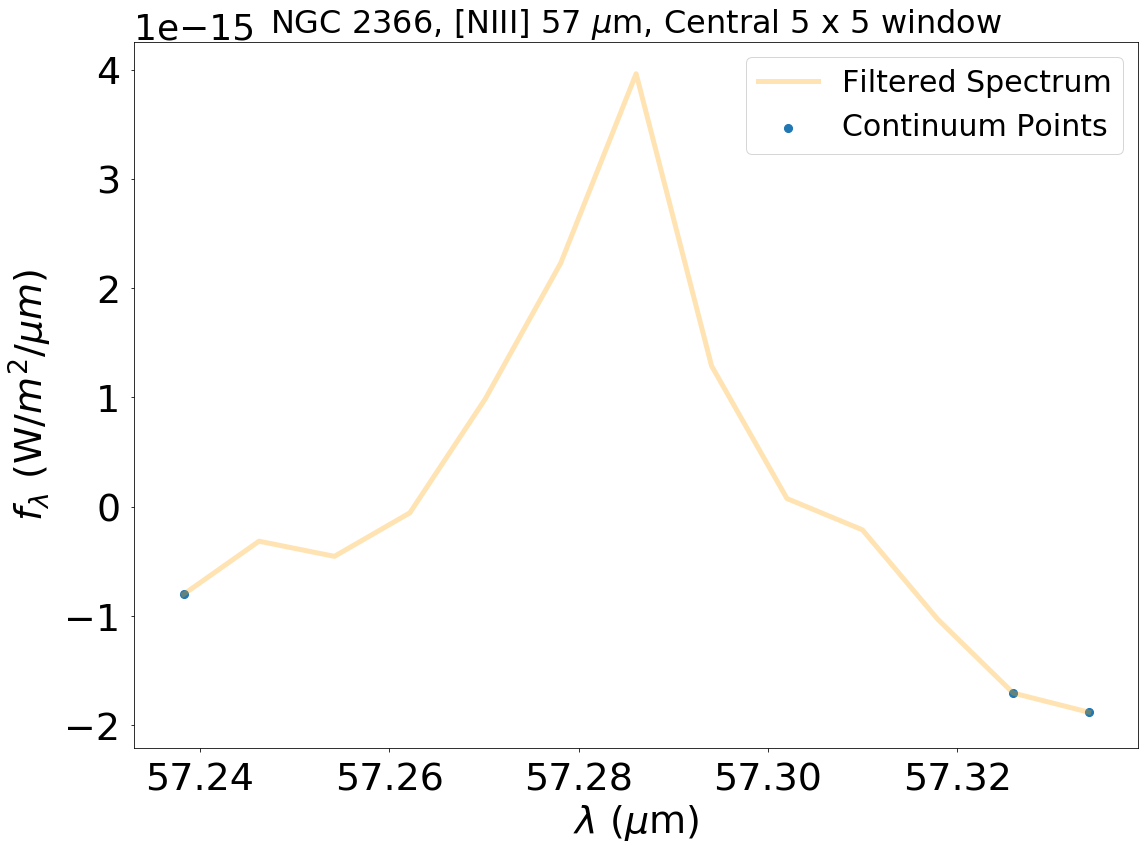

In [38]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Filtered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + 'NGC_2366_[NIII]-2-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

In [39]:
idcont = np.isfinite(central_fluxes_filtered_continuum)
cont_params = np.polyfit(wavelengths_filtered[idcont], central_fluxes_filtered_continuum[idcont], 1)

print(cont_params)

cont_line_filtered = cont_params[0]*wavelengths_filtered + cont_params[1]

[-1.08848209e-14  6.22230097e-13]


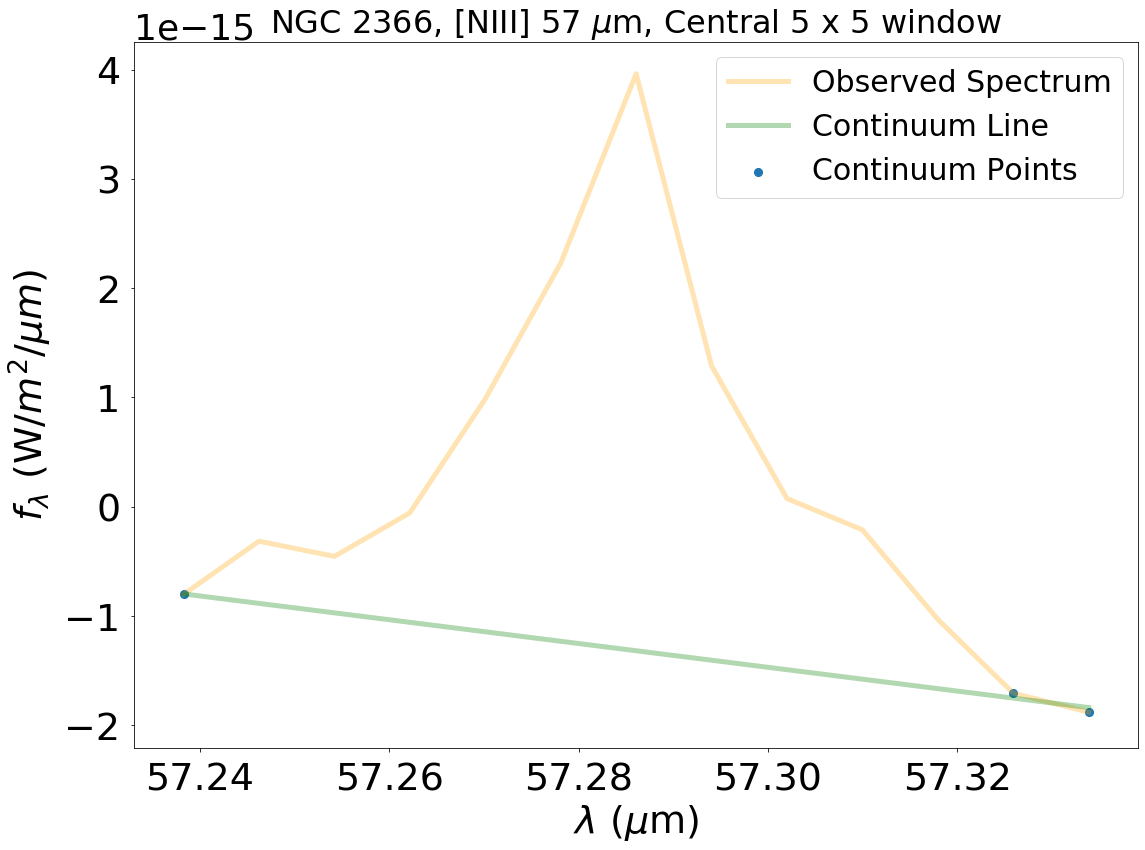

In [40]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelengths_filtered, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + 'NGC_2366_[NIII]-3-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

In [41]:
id_act = np.isnan(central_fluxes_filtered_continuum)

wavelengths_act = wavelengths_filtered[id_act]
central_fluxes_filtered_act = central_fluxes_filtered[id_act]
cont_line_filtered_act = cont_line_filtered[id_act]

central_fluxes_continuum_subtracted_act = central_fluxes_filtered_act - cont_line_filtered_act

[5.68989948e-16 5.17082694e-16 1.00199725e-15 2.13144202e-15
 3.46047850e-15 5.28007113e-15 2.69363195e-15 1.56609854e-15
 1.36658608e-15 6.33918276e-16]


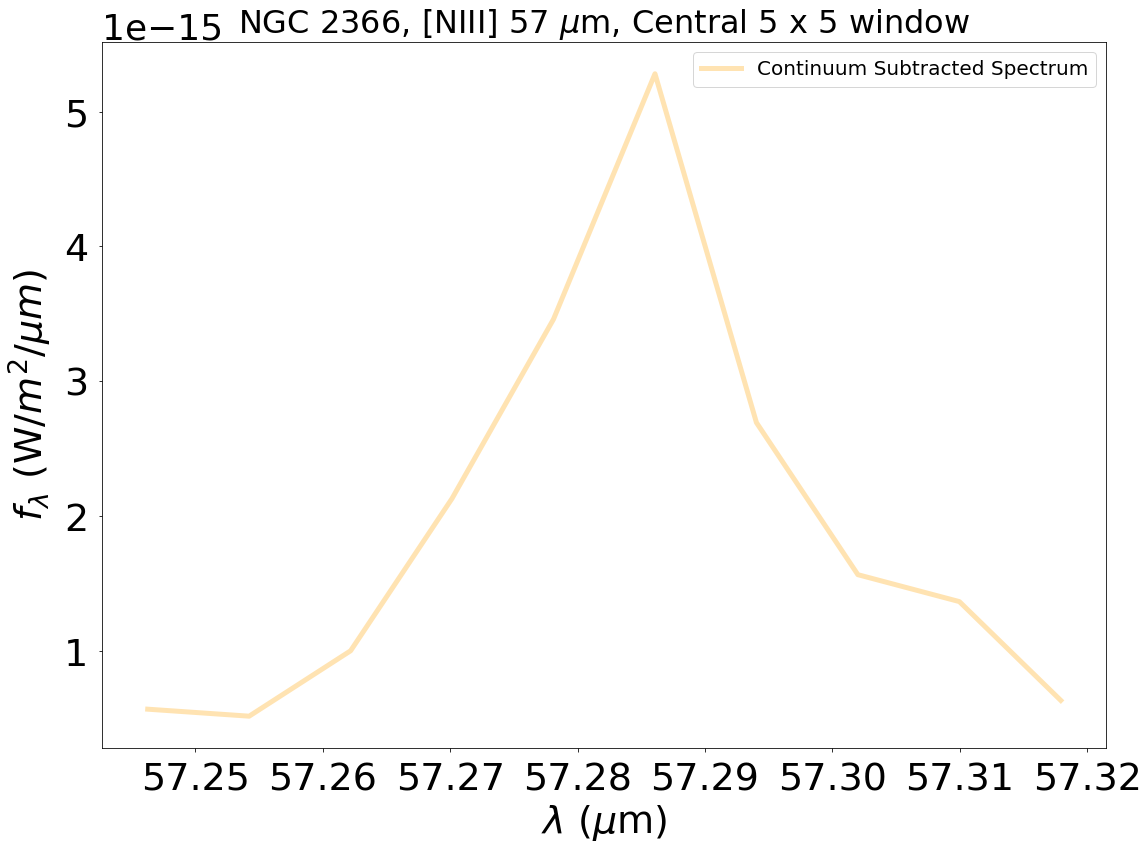

In [42]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, label = 'Continuum Subtracted Spectrum', lw = 5, color = 'orange', alpha = 0.3)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_2366_[NIII]-4-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

print(central_fluxes_continuum_subtracted_act)

In [43]:
def fit_func_1(Z, peak_height, mu, sigma):
    
    P = peak_height*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

In [44]:
heights = central_fluxes_continuum_subtracted_act/np.max(central_fluxes_continuum_subtracted_act)

centers = wavelengths_act

# Information about the peak in the numerical PDF
peak_ind = np.where(heights == np.max(heights))[0][0]
peak_height = np.max(heights)

# mu is where the numerical PDF peaks
mu = centers[peak_ind]

# Estimating sigma using FWHM
sigma = 0

for i in range(0, peak_ind):
    if(heights[i] >= peak_height/2):
        sigma = (mu - centers[i])/np.sqrt(2*np.log(2))
        break

# First fit a Gaussian

guess_params = np.array([peak_height, sigma])
fit_params, fit_covar = optimize.curve_fit(lambda centers, peak_height, sigma: 
                                           fit_func_1(centers, peak_height, mu, sigma), 
                                           centers, heights, p0=guess_params)

fit_params = [fit_params[0], mu, fit_params[1]]

fit_params[0] *= np.max(central_fluxes_continuum_subtracted_act)

print(fit_params)

[4.3115020617162485e-15, 57.28607893493228, 0.013321752979689547]


[4.95347598e-17 6.18189346e-17 7.67159762e-17 9.46679472e-17
 1.16164372e-16 1.41741094e-16 1.71977432e-16 2.07491343e-16
 2.48932355e-16 2.96972038e-16 3.52291865e-16 4.15568400e-16
 4.87455821e-16 5.68565954e-16 6.59446070e-16 7.60554890e-16
 8.72237363e-16 9.94698937e-16 1.12798017e-15 1.27193267e-15
 1.42619735e-15 1.59018616e-15 1.76306839e-15 1.94376248e-15
 2.13093437e-15 2.32300315e-15 2.51815447e-15 2.71436209e-15
 2.90941744e-15 3.10096697e-15 3.28655638e-15 3.46368093e-15
 3.62984027e-15 3.78259631e-15 3.91963223e-15 4.03881062e-15
 4.13822884e-15 4.21626949e-15 4.27164414e-15 4.30342871e-15
 4.31108916e-15 4.29449639e-15 4.25392985e-15 4.19006972e-15
 4.10397796e-15 3.99706890e-15 3.87107062e-15 3.72797849e-15
 3.57000272e-15 3.39951170e-15 3.21897333e-15 3.03089618e-15
 2.83777257e-15 2.64202522e-15 2.44595901e-15 2.25171922e-15
 2.06125698e-15 1.87630264e-15 1.69834721e-15 1.52863191e-15
 1.36814524e-15 1.21762718e-15 1.07757946e-15 9.48281159e-16
 8.29808317e-16 7.220566

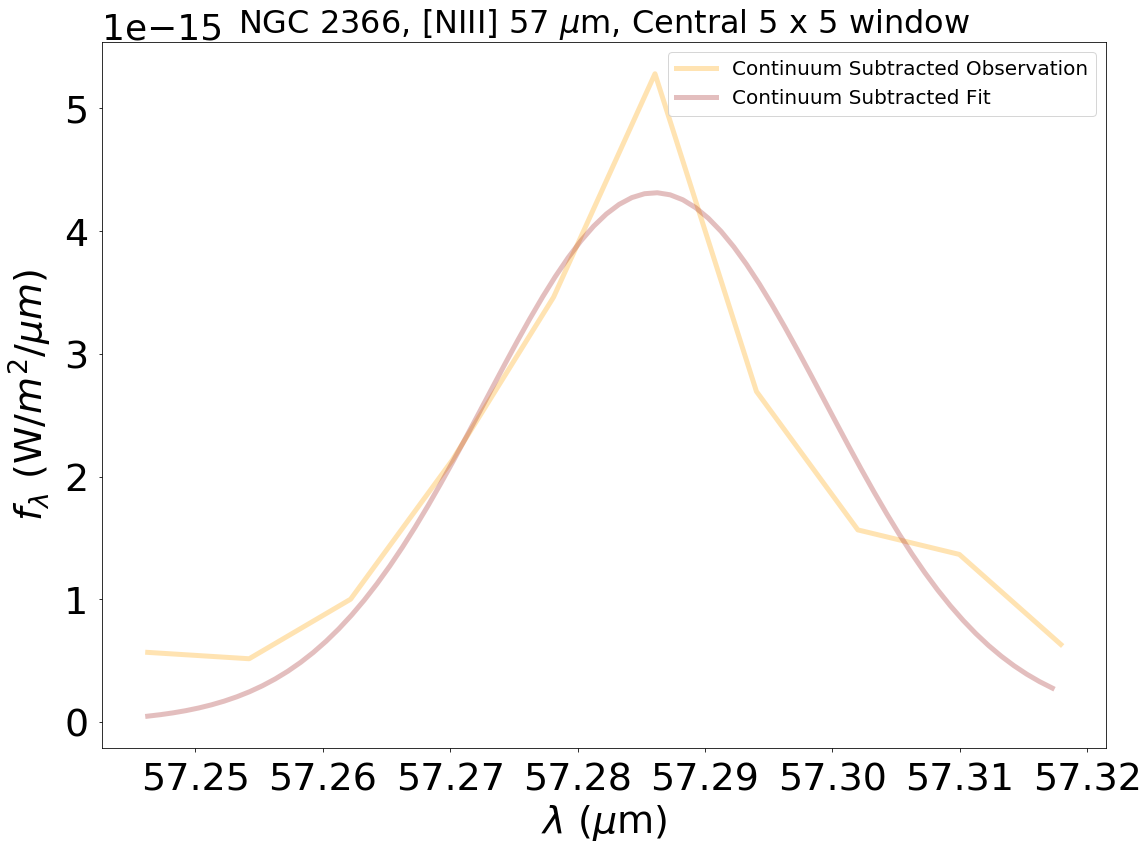

In [46]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_act), np.max(wavelengths_act), 0.001)

fitted_central_fluxes_continuum_subtracted_act = fit_func_1(wavelength_range, *fit_params)

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Observation', lw = 5, color = 'orange', alpha = 0.3)

ax.plot(wavelength_range, fitted_central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Fit', lw = 5, color = 'brown', alpha = 0.3)


ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_2366_[NIII]-5-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

[4.95347598e-17 6.18189346e-17 7.67159762e-17 9.46679472e-17
 1.16164372e-16 1.41741094e-16 1.71977432e-16 2.07491343e-16
 2.48932355e-16 2.96972038e-16 3.52291865e-16 4.15568400e-16
 4.87455821e-16 5.68565954e-16 6.59446070e-16 7.60554890e-16
 8.72237363e-16 9.94698937e-16 1.12798017e-15 1.27193267e-15
 1.42619735e-15 1.59018616e-15 1.76306839e-15 1.94376248e-15
 2.13093437e-15 2.32300315e-15 2.51815447e-15 2.71436209e-15
 2.90941744e-15 3.10096697e-15 3.28655638e-15 3.46368093e-15
 3.62984027e-15 3.78259631e-15 3.91963223e-15 4.03881062e-15
 4.13822884e-15 4.21626949e-15 4.27164414e-15 4.30342871e-15
 4.31108916e-15 4.29449639e-15 4.25392985e-15 4.19006972e-15
 4.10397796e-15 3.99706890e-15 3.87107062e-15 3.72797849e-15
 3.57000272e-15 3.39951170e-15 3.21897333e-15 3.03089618e-15
 2.83777257e-15 2.64202522e-15 2.44595901e-15 2.25171922e-15
 2.06125698e-15 1.87630264e-15 1.69834721e-15 1.52863191e-15
 1.36814524e-15 1.21762718e-15 1.07757946e-15 9.48281159e-16
 8.29808317e-16 7.220566

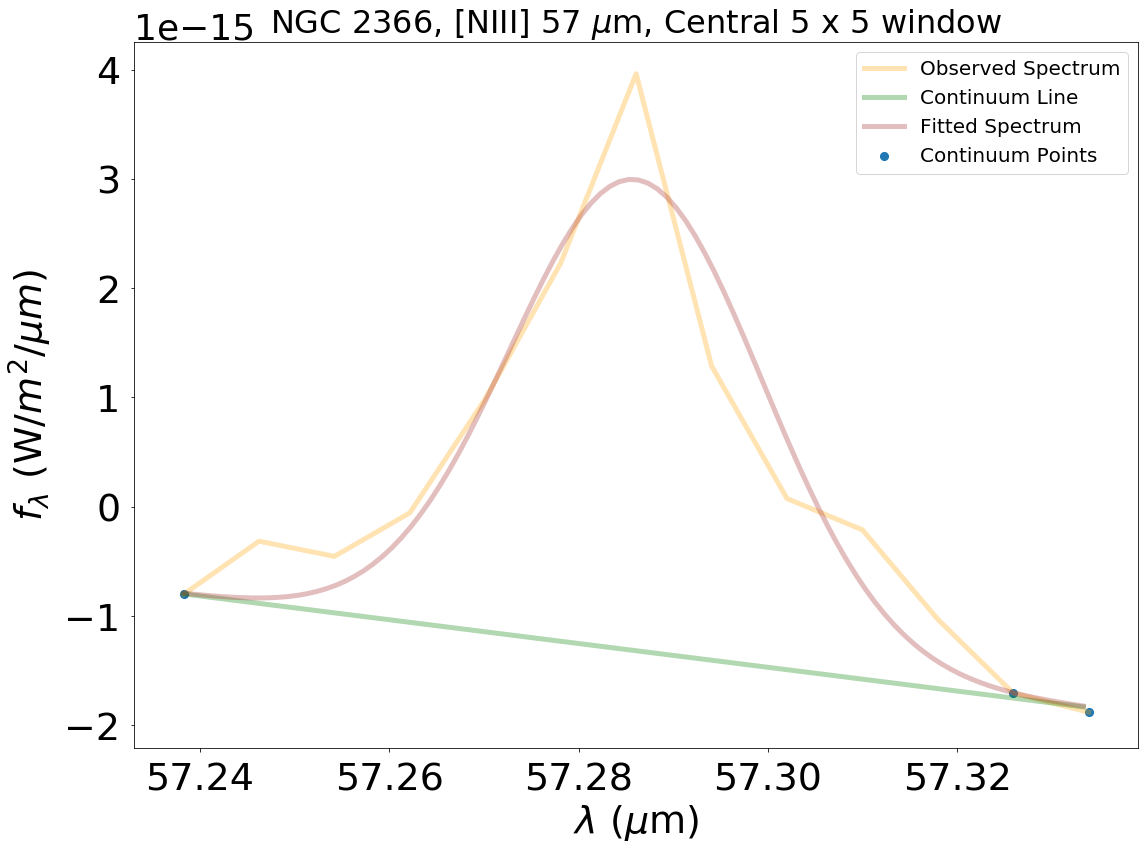

In [47]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_filtered), np.max(wavelengths_filtered), 0.001)
cont_line_filtered = cont_params[0]*wavelength_range + cont_params[1]
fitted_central_fluxes_act = fit_func_1(wavelength_range, *fit_params) + cont_line_filtered

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 2366, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_2366_[NIII]-6-final_spectrum.png'.format(str(n_x), str(n_y)))

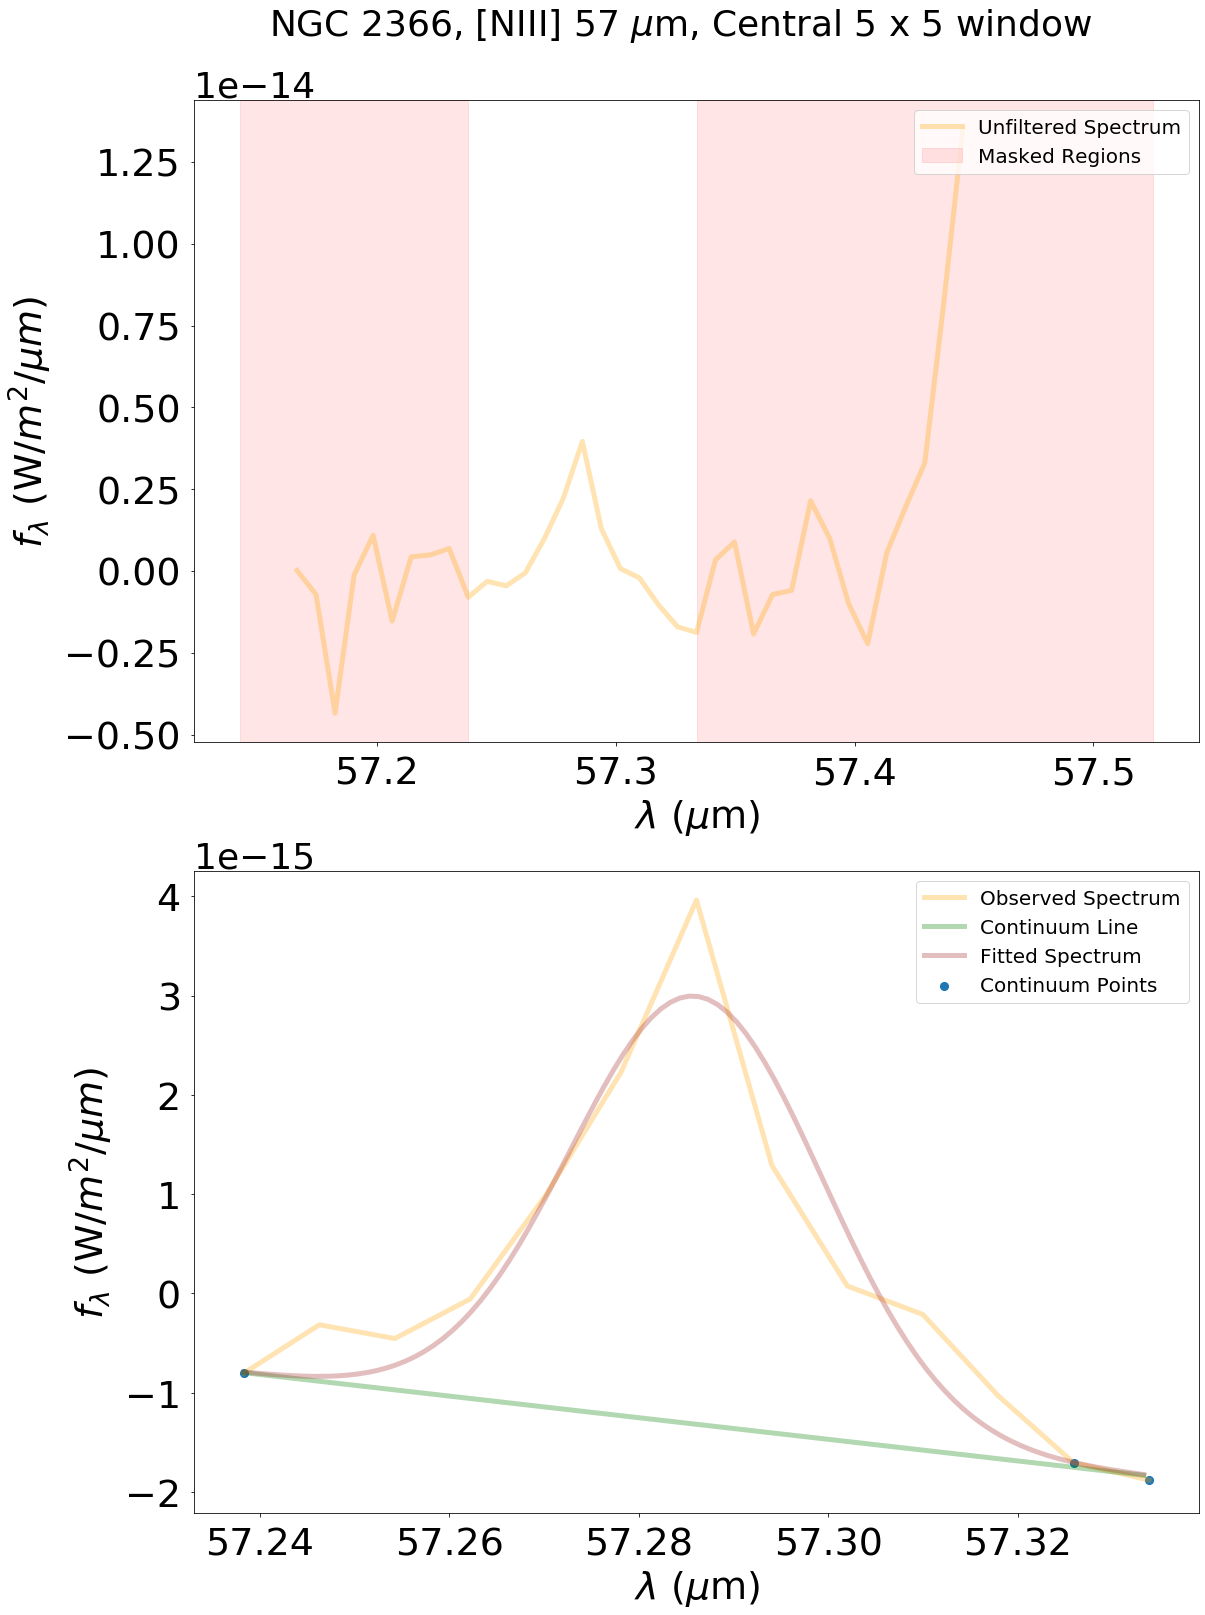

In [51]:
fig, axs = plt.subplots(2, 1, figsize = (18, 26))

ax1 = axs[0]

ax1.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax1.axvspan(wavelengths[0], wavelengths[12], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax1.axvspan(wavelengths[-25], wavelengths[-1], color = 'red', alpha = 0.1)

ax1.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax1.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax1.tick_params(labelsize = 38, pad = 10)
ax1.yaxis.offsetText.set_fontsize(36)
ax1.legend(prop={'size': 20}, loc = 'upper right')

ax2 = axs[1]

ax2.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax2.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax2.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax2.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax2.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax2.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax2.tick_params(labelsize = 38, pad = 10)
ax2.yaxis.offsetText.set_fontsize(36)
ax2.legend(prop={'size': 20}, loc = 'upper right')

fig.suptitle(r'NGC 2366, [NIII] 57 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 36, y = 0.93)

plt.savefig(savedir + 'NGC_2366_[NIII]-7-summary_spectrum.png'.format(str(n_x), str(n_y)))

In [49]:
flux_continuum = np.trapz(cont_line_filtered, x = wavelength_range, dx = wav_diff)

flux_obs = np.trapz(central_fluxes_filtered, x = wavelengths_filtered, dx = wav_diff)
flux_obs_sub = flux_obs - flux_continuum
print('Flux of the continuum subtracted observation = ' + str(flux_obs_sub) + ' W/m^2')

flux_fit = np.trapz(fitted_central_fluxes_act, x = wavelength_range, dx = wav_diff)
flux_fit_sub = flux_fit - flux_continuum
print('Flux of the continuum subtracted fit = ' + str(flux_fit_sub) + ' W/m^2')

print('Spectral width = ' + str(str(2*np.sqrt(np.log(2))*fit_params[2])) + r' microns')

Flux of the continuum subtracted observation = 1.5221291536212478e-16 W/m^2
Flux of the continuum subtracted fit = 1.4391986426325066e-16 W/m^2
Spectral width = 0.022182173743888662 microns
